<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/utomoreza/assessment-mini-project/blob/main/notebook/usecase-image.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/utomoreza/assessment-mini-project/blob/main/notebook/usecase-image.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://raw.githubusercontent.com/utomoreza/assessment-mini-project/main/notebook/usecase-image.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In [1]:
!pip install -q portalocker==2.8.2 datasets==2.19.0 tensorflow==2.15.1 keras==2.15.0 tf-keras==2.15.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 33.5 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
print("TF version:", tf.__version__)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

TF version: 2.15.1
Found GPU at: /device:GPU:0


# Metadata
The dataset used is CIFAR-10. You can read its explanation in this [webpage](https://www.kaggle.com/c/cifar-10/data).

The label classes in the dataset are:
<ol start="0">
    <li>airplane</li>
    <li>automobile</li>
    <li>bird</li>
    <li>cat</li>
    <li>deer</li>
    <li>dog</li>
    <li>frog</li>
    <li>horse</li>
    <li>ship</li>
    <li>truck</li>
</ol>

In [3]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report
)

import tensorflow as tf
import keras
from keras.preprocessing import image
from keras.datasets import cifar10

In [4]:
TEST_SIZE = 0.4
BATCH_SIZE = 64
EPOCHS = 50

In [79]:
# Normalize the data.
def normalize(X):
    X = X.astype('float32')
    X /= 255.0
    return X


def show_image(idx, X, y, mapper):
    plt.imshow(X[idx])
    label = y[idx][0]
    print("Label:", mapper[label])


def plotmodelhistory(history):
    fig, axs = plt.subplots(2, 2,figsize=(12, 5))
    # summarize history for accuracy
    axs[0][0].plot(history.history['categorical_accuracy'])
    axs[0][0].plot(history.history['val_categorical_accuracy'])
    axs[0][0].set_title('Model Categorical Accuracy')
    axs[0][0].set_ylabel('Categorical Accuracy')
    axs[0][0].set_xlabel('Epoch')

    axs[0][0].legend(['train', 'validate'], loc='upper left')

    # summarize history for loss
    axs[0][1].plot(history.history['loss'])
    axs[0][1].plot(history.history['val_loss'])
    axs[0][1].set_title('Model Loss')
    axs[0][1].set_ylabel('Loss')
    axs[0][1].set_xlabel('Epoch')
    axs[0][1].legend(['train', 'validate'], loc='upper left')

    # summarize history for precision
    axs[1][0].plot(history.history['precision'])
    axs[1][0].plot(history.history['val_precision'])
    axs[1][0].set_title('Model Precision')
    axs[1][0].set_ylabel('Precision')
    axs[1][0].set_xlabel('Epoch')
    axs[1][0].legend(['train', 'validate'], loc='upper left')

    # summarize history for recall
    axs[1][1].plot(history.history['recall'])
    axs[1][1].plot(history.history['val_recall'])
    axs[1][1].set_title('Model Recall')
    axs[1][1].set_ylabel('Recall')
    axs[1][1].set_xlabel('Epoch')
    axs[1][1].legend(['train', 'validate'], loc='upper left')

#     # summarize history for f1-score
#     axs[2][0].plot(history.history['f1_score'])
#     axs[2][0].plot(history.history['val_f1_score'])
#     axs[2][0].set_title('Model F1 Score')
#     axs[2][0].set_ylabel('F1 Score')
#     axs[2][0].set_xlabel('Epoch')
#     axs[2][0].legend(['train', 'validate'], loc='upper left')

    fig.tight_layout()
    plt.show()


def prediction_reports(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)

    # create confusion matrix plot
    cm = confusion_matrix(
        np.argmax(y_test, axis=1),
        y_pred,
        labels=list(code_to_label.keys())
    )
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=list(code_to_label.values())
    )

    # create classification report
    report = classification_report(
        np.argmax(y_test, axis=1),
        y_pred,
        output_dict=True
    )

    df = pd.DataFrame(report).transpose()

    disp.plot()
    plt.xticks(rotation=45)
    plt.show()

    return cm, df


def save_model(model, save_path):
    if not os.path.exists(save_path):
        # Create the directory
        os.makedirs(save_path)

    # save entire model
    model.save(os.path.join(save_path, "model.keras"))
    print(f"The entire model saved successfully in {save_path}")


def load_model(save_path):
    # load trained model
    trained_model = tf.keras.models.load_model(f"{save_path}/model.keras")
    return trained_model


def predict_from_file(model, img_path):
    # preprocess
    # get target_size from the dimensions of 1st layer
    target_size = model.layers[0].output_shape[1:]
    img = image.load_img(img_path, target_size=target_size)
    example = image.img_to_array(img)
    example = np.expand_dims(example, axis=0)
    example = normalize(example)

    # predict
    pred = model.predict(example)
    y_pred = np.argmax(pred)
    proba = np.max(pred)
    pred_label = code_to_label[y_pred]

    return y_pred, pred_label, proba

In [6]:
# Adding TF Cifar10 Data ..
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 2s 0us/step


In [7]:
X_val, X_test, y_val, y_test = train_test_split(
    X_test, y_test, test_size=TEST_SIZE, shuffle=True
)

In [ ]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 1)
(6000, 32, 32, 3) (6000, 1)
(4000, 32, 32, 3) (4000, 1)


In [8]:
code_to_label = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck"
}

In [9]:
num_classes = len(code_to_label)

Label: automobile


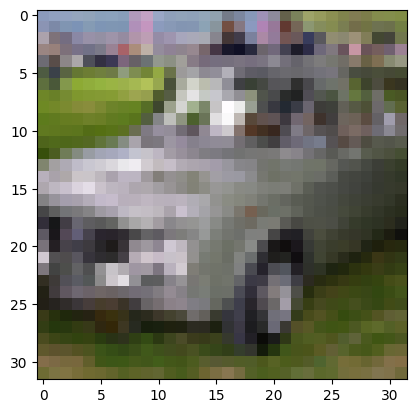

In [10]:
idx = 44
show_image(idx, X_train, y_train, code_to_label)

# Data Preprocessing

In [10]:
X_train = normalize(X_train)
X_val = normalize(X_val)
X_test = normalize(X_test)

In [11]:
# on-hot encoded to 10 classes
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# Modelling

## Training

In [13]:
def identity_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [14]:
def convolutional_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same', strides = (2,2))(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Processing Residue with conv(1,1)
    x_skip = tf.keras.layers.Conv2D(filter, (1,1), strides = (2,2))(x_skip)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [15]:
def ResNet34(shape=(32, 32, 3), classes=10):
    # Step 1 (Setup Input Layer)
    x_input = tf.keras.layers.Input(shape)
    x = tf.keras.layers.ZeroPadding2D((3, 3))(x_input)
    # Step 2 (Initial Conv layer along with maxPool)
    x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    # Define size of sub-blocks and initial filter size
    block_layers = [3, 4, 6, 3]
    filter_size = 64
    # Step 3 Add the Resnet Blocks
    for i in range(4):
        if i == 0:
            # For sub-block 1 Residual/Convolutional block not needed
            for j in range(block_layers[i]):
                x = identity_block(x, filter_size)
        else:
            # One Residual/Convolutional Block followed by Identity blocks
            # The filter size will go on increasing by a factor of 2
            filter_size = filter_size*2
            x = convolutional_block(x, filter_size)
            for j in range(block_layers[i] - 1):
                x = identity_block(x, filter_size)
    # Step 4 End Dense Network
    x = tf.keras.layers.AveragePooling2D((2,2), padding='same')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dense(classes, activation='softmax')(x)
    model = tf.keras.models.Model(inputs=x_input, outputs=x, name="ResNet34")
    return model

In [16]:
model = ResNet34()

In [74]:
dot_img_file = "/content/model_resnet.png"

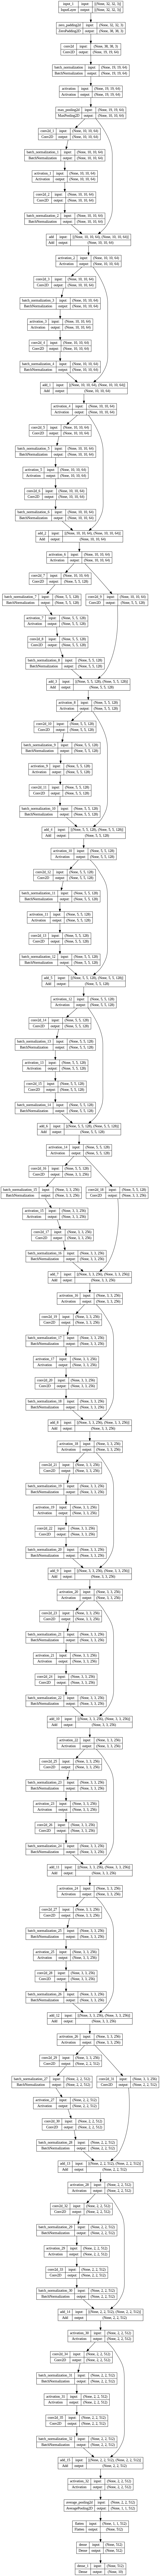

In [75]:
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [17]:
model.compile(
    optimizer="adam", loss='categorical_crossentropy',
    metrics=["categorical_accuracy",
             tf.keras.metrics.Precision(),
             tf.keras.metrics.Recall(),
             tf.keras.metrics.F1Score()]
)

In [24]:
model.summary()

Model: "ResNet34"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 38, 38, 3)            0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv2d (Conv2D)             (None, 19, 19, 64)           9472      ['zero_padding2d[0][0]']      
                                                                                                  
 batch_normalization (Batch  (None, 19, 19, 64)           256       ['conv2d[0][0]']       

In [18]:
callback = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=3, restore_best_weights=True
)

In [19]:
history = model.fit(
    X_train, y_train, batch_size=BATCH_SIZE,
    epochs=EPOCHS, shuffle=True,
    validation_data=(X_val, y_val),
    callbacks=[callback]
)

Epoch 1/50
782/782 [==============================] - 49s 32ms/step - loss: 1.6239 - categorical_accuracy: 0.4085 - precision: 0.6316 - recall: 0.2074 - f1_score: 0.4040 - val_loss: 1.7280 - val_categorical_accuracy: 0.4060 - val_precision: 0.5185 - val_recall: 0.2615 - val_f1_score: 0.4009
Epoch 2/50
782/782 [==============================] - 22s 28ms/step - loss: 1.1595 - categorical_accuracy: 0.5863 - precision: 0.7322 - recall: 0.4389 - f1_score: 0.5843 - val_loss: 1.3702 - val_categorical_accuracy: 0.5398 - val_precision: 0.6150 - val_recall: 0.4657 - val_f1_score: 0.5278
Epoch 3/50
782/782 [==============================] - 22s 28ms/step - loss: 0.9482 - categorical_accuracy: 0.6672 - precision: 0.7740 - recall: 0.5586 - f1_score: 0.6661 - val_loss: 1.1746 - val_categorical_accuracy: 0.6105 - val_precision: 0.7269 - val_recall: 0.5053 - val_f1_score: 0.6078
Epoch 4/50
782/782 [==============================] - 22s 28ms/step - loss: 0.8131 - categorical_accuracy: 0.7166 - precisio

## Evaluating

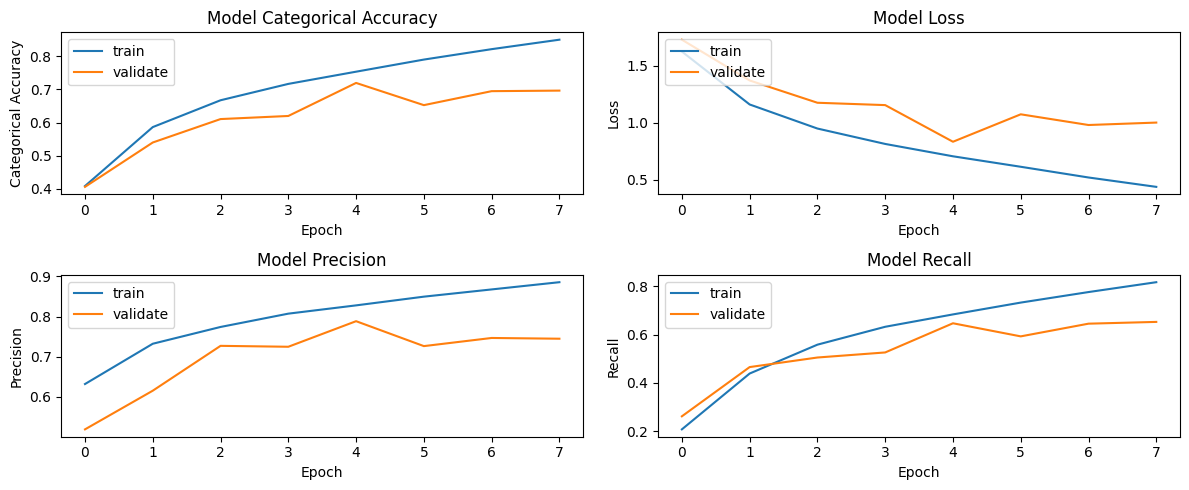

In [80]:
# list all data in history
plotmodelhistory(history)

In [76]:
test_loss, test_acc, test_prec, test_rec, test_f1score = model.evaluate(X_test, y_test)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)
print("Test Precision:", test_prec)
print("Test Recall:", test_rec)
for idx, score in enumerate(test_f1score):
    print(f"Test F1-Score for label {idx}-{code_to_label[idx]}:", score)

125/125 [==============================] - 1s 6ms/step - loss: 0.8623 - categorical_accuracy: 0.7032 - precision: 0.7790 - recall: 0.6320 - f1_score: 0.6991
Test Loss: 0.8623449802398682
Test Accuracy: 0.703249990940094
Test Precision: 0.7790446877479553
Test Recall: 0.6320000290870667
Test F1-Score for label 0-airplane: 0.73788816
Test F1-Score for label 1-automobile: 0.8013777
Test F1-Score for label 2-bird: 0.6300268
Test F1-Score for label 3-cat: 0.46315792
Test F1-Score for label 4-deer: 0.67796606
Test F1-Score for label 5-dog: 0.63016766
Test F1-Score for label 6-frog: 0.79512197
Test F1-Score for label 7-horse: 0.7270693
Test F1-Score for label 8-ship: 0.7815385
Test F1-Score for label 9-truck: 0.746336


125/125 [==============================] - 1s 4ms/step


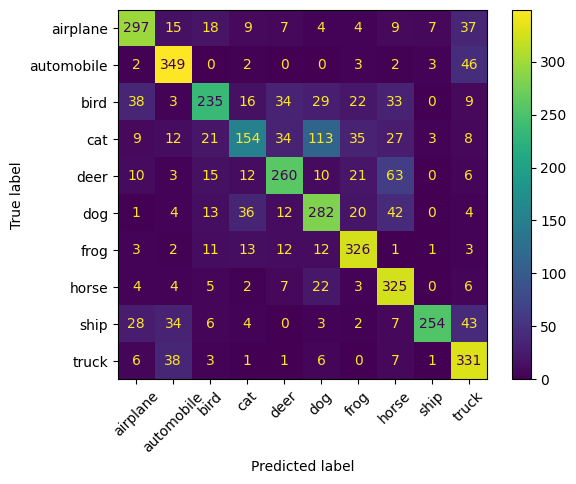

In [67]:
_, report_df = prediction_reports(model, X_test, y_test)

In [68]:
report_df

,precision,recall,f1-score,support
0,0.746231,0.729730,0.737888,407.00000
1,0.752155,0.857494,0.801378,407.00000
2,0.718654,0.560859,0.630027,419.00000
3,0.618474,0.370192,0.463158,416.00000
4,0.708447,0.650000,0.677966,400.00000
5,0.586279,0.681159,0.630168,414.00000
6,0.747706,0.848958,0.795122,384.00000
7,0.629845,0.859788,0.727069,378.00000
8,0.944238,0.666667,0.781538,381.00000
9,0.671400,0.840102,0.746336,394.00000


## Save Entire Model

In [72]:
save_path = "/content/model/usecase-image"
save_model(model, save_path)

The entire model saved successfully in /content/model/usecase-image


In [73]:
trained_model = load_model(save_path)
trained_model.summary()

Model: "ResNet34"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 38, 38, 3)            0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv2d (Conv2D)             (None, 19, 19, 64)           9472      ['zero_padding2d[0][0]']      
                                                                                                  
 batch_normalization (Batch  (None, 19, 19, 64)           256       ['conv2d[0][0]']       

# Prediction

In [ ]:
img_path = "/content/kodok.jpg"

In [69]:
!wget -O {img_path} https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR3s4EWxQtMS557iW24-EQrz6lj5scDEXTEdiOAsnxQ5A&s

/bin/bash: line 1: s: command not found
--2024-05-05 14:08:25--  https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR3s4EWxQtMS557iW24-EQrz6lj5scDEXTEdiOAsnxQ5A
Resolving encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)... 172.217.214.113, 172.217.214.102, 172.217.214.101, ...
Connecting to encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)|172.217.214.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9241 (9.0K) [image/jpeg]
Saving to: ‘/content/kodok.jpg’

/content/kodok.jpg  100%[===================>]   9.02K  --.-KB/s    in 0s      

2024-05-05 14:08:25 (112 MB/s) - ‘/content/kodok.jpg’ saved [9241/9241]



In [ ]:
predict_from_file(model, img_path)

1/1 [==============================] - 0s 23ms/step


(6, 'frog', 0.63908195)